In [77]:
import os
import logging
from tqdm import tqdm
from PIL import Image

In [78]:
# logging settings
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [79]:
def check_is_dir(path):
    if not os.path.isdir(path):
        raise ValueError(f"Provided path: {path} is not a directory")
    return True

In [80]:
def filter_images(list_of_files):
    valid_extensions = {".jpg", ".png", ".jpeg", ".webp"}
    return [
        file
        for file in list_of_files
        if any(file.endswith(ext) for ext in valid_extensions)
    ]

In [81]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

In [82]:
def read_images_from_dir(dir_path):
    check_is_dir(dir_path)
    files = os.listdir(dir_path)
    image_files = filter_images(files)
    image_paths = [os.path.join(dir_path, file) for file in image_files]
    images = [load_image(image_path) for image_path in tqdm(image_paths)]
    logging.info(f"Loaded {len(images)} images from {dir_path}")
    return images

In [83]:
loaded_images = read_images_from_dir("raw_images/horse")

 60%|██████    | 135/225 [00:08<00:08, 10.47it/s]d:\anaconda\envs\classifier\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 225/225 [00:12<00:00, 18.11it/s]
2024-09-27 21:02:14,310 - INFO - Loaded 225 images from raw_images/horse


In [84]:
def max_resolution_rescale(image, max_width, max_height):
    width, height = image.size
    if width > max_width or height > max_height:
        ratio = min(max_width / width, max_height / height)
        new_width = int(width * ratio)
        new_height = int(height * ratio)
        image = image.resize((new_width, new_height), Image.LANCZOS)
    return image

In [85]:
max_size = 1024

resized_images = list(
    map(lambda x: max_resolution_rescale(x, max_size, max_size), tqdm(loaded_images))
)

100%|██████████| 225/225 [00:03<00:00, 69.86it/s]


In [86]:
def min_resolution_filter(image, min_width, min_height):
    width, height = image.size
    return width >= min_width and height >= min_height

In [87]:
min_size = 224
filtered_images = list(
    filter(lambda x: min_resolution_filter(x, min_size, min_size), tqdm(resized_images))
)

100%|██████████| 225/225 [00:00<?, ?it/s]


In [88]:
len(filtered_images)

209

## Image Cropping

In [89]:
import matplotlib.pyplot as plt

In [90]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()

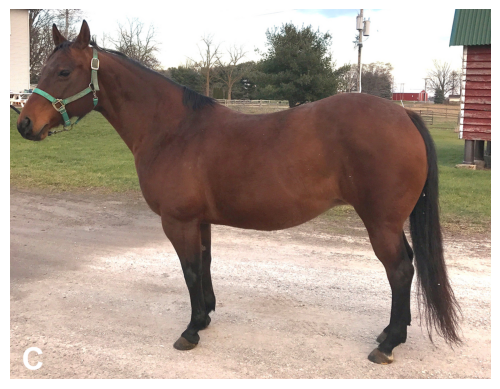

In [91]:
plot_image(filtered_images[14])

In [92]:
def center_crop(image, new_width, new_height):
    width, height = image.size
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    cropped_image = image.crop((left, top, right, bottom))
    logging.info(f"Center cropped image to {new_width}x{new_height}")
    return cropped_image

2024-09-27 21:02:18,187 - INFO - Center cropped image to 224x224


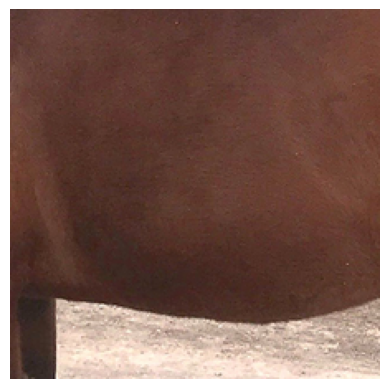

In [93]:
min_size = 224

plot_image(center_crop(filtered_images[14], min_size, min_size))

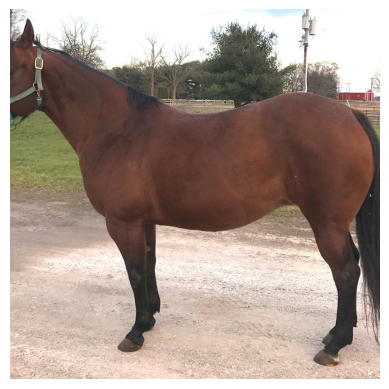

In [94]:
from smartcrop import detect

cropped_image = detect(filtered_images[14], square=True)
plot_image(cropped_image)

In [95]:
cropped_images = list(map(lambda x: detect(x, square=True), tqdm(filtered_images)))

100%|██████████| 209/209 [00:14<00:00, 14.58it/s]


## Saving

In [96]:
import numpy as np

In [97]:
def save_image(image, save_path):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    if not isinstance(image, Image.Image):
        raise ValueError("Input image must be a numpy array or PIL Image")

    if image.mode != "RGB":
        image = image.convert("RGB")

    image.save(save_path)
    logging.info(f"Saved image to {save_path}")

In [98]:
def create_directory(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
        print(f"Directory created: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

In [99]:
def save_images_to_dir(images, dir_path):
    create_directory(dir_path)
    check_is_dir(dir_path)

    for i, image in tqdm(enumerate(images, 1)):
        save_path = os.path.join(dir_path, f"image_{i}.jpg")
        save_image(image, save_path)
    return True

In [100]:
save_images_to_dir(cropped_images, "processed_images/horse")

Directory created: processed_images/horse


0it [00:00, ?it/s]2024-09-27 21:02:33,195 - INFO - Saved image to processed_images/horse\image_1.jpg
2024-09-27 21:02:33,214 - INFO - Saved image to processed_images/horse\image_2.jpg
2024-09-27 21:02:33,234 - INFO - Saved image to processed_images/horse\image_3.jpg
2024-09-27 21:02:33,241 - INFO - Saved image to processed_images/horse\image_4.jpg
2024-09-27 21:02:33,256 - INFO - Saved image to processed_images/horse\image_5.jpg
2024-09-27 21:02:33,284 - INFO - Saved image to processed_images/horse\image_6.jpg
2024-09-27 21:02:33,290 - INFO - Saved image to processed_images/horse\image_7.jpg
7it [00:00, 67.28it/s]2024-09-27 21:02:33,306 - INFO - Saved image to processed_images/horse\image_8.jpg
2024-09-27 21:02:33,311 - INFO - Saved image to processed_images/horse\image_9.jpg
2024-09-27 21:02:33,319 - INFO - Saved image to processed_images/horse\image_10.jpg
2024-09-27 21:02:33,332 - INFO - Saved image to processed_images/horse\image_11.jpg
2024-09-27 21:02:33,339 - INFO - Saved image 

True